In [51]:
import glob
import json
import os
import shutil
import operator
import sys
import argparse
import math

import numpy as np

#import cv2
#import matplotlib.pyplot as plt

# utility functions for mAP evaluation

def log_average_miss_rate(prec, rec, num_images):
    """
        log-average miss rate:
            Calculated by averaging miss rates at 9 evenly spaced FPPI points
            between 10e-2 and 10e0, in log-space.

        output:
                lamr | log-average miss rate
                mr | miss rate
                fppi | false positives per image

        references:
            [1] Dollar, Piotr, et al. "Pedestrian Detection: An Evaluation of the
               State of the Art." Pattern Analysis and Machine Intelligence, IEEE
               Transactions on 34.4 (2012): 743 - 761.
    """

    # if there were no detections of that class
    if prec.size == 0:
        lamr = 0
        mr = 1
        fppi = 0
        return lamr, mr, fppi

    fppi = (1 - prec)
    mr = (1 - rec)

    fppi_tmp = np.insert(fppi, 0, -1.0)
    mr_tmp = np.insert(mr, 0, 1.0)

    # Use 9 evenly spaced reference points in log-space
    ref = np.logspace(-2.0, 0.0, num = 9)
    for i, ref_i in enumerate(ref):
        # np.where() will always find at least 1 index, since min(ref) = 0.01 and min(fppi_tmp) = -1.0
        j = np.where(fppi_tmp <= ref_i)[-1][-1]
        ref[i] = mr_tmp[j]

    # log(0) is undefined, so we use the np.maximum(1e-10, ref)
    lamr = math.exp(np.mean(np.log(np.maximum(1e-10, ref))))

    return lamr, mr, fppi

"""
 throw error and exit
"""
def error(msg):
    print(msg)
    sys.exit(0)

"""
 check if the number is a float between 0.0 and 1.0
"""
def is_float_between_0_and_1(value):
    try:
        val = float(value)
        if val > 0.0 and val < 1.0:
            return True
        else:
            return False
    except ValueError:
        return False

"""
 Calculate the AP given the recall and precision array
    1st) We compute a version of the measured precision/recall curve with
         precision monotonically decreasing
    2nd) We compute the AP as the area under this curve by numerical integration.
"""
def voc_ap(rec, prec):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre


"""
 Convert the lines of a file to a list
"""
def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content]
    return content

"""
 Draws text in image
"""
def draw_text_in_image(img, text, pos, color, line_width):
    font = cv2.FONT_HERSHEY_PLAIN
    fontScale = 1
    lineType = 1
    bottomLeftCornerOfText = pos
    cv2.putText(img, text,
            bottomLeftCornerOfText,
            font,
            fontScale,
            color,
            lineType)
    text_width, _ = cv2.getTextSize(text, font, fontScale, lineType)[0]
    return img, (line_width + text_width)

"""
 Plot - adjust axes
"""
def adjust_axes(r, t, fig, axes):
    # get text width for re-scaling
    bb = t.get_window_extent(renderer=r)
    text_width_inches = bb.width / fig.dpi
    # get axis width in inches
    current_fig_width = fig.get_figwidth()
    new_fig_width = current_fig_width + text_width_inches
    propotion = new_fig_width / current_fig_width
    # get axis limit
    x_lim = axes.get_xlim()
    axes.set_xlim([x_lim[0], x_lim[1]*propotion])

"""
 Draw plot using Matplotlib
"""
def draw_plot_func(dictionary, n_classes, window_title, plot_title, x_label, output_path, to_show, plot_color, true_p_bar):
    # sort the dictionary by decreasing value, into a list of tuples
    sorted_dic_by_value = sorted(dictionary.items(), key=operator.itemgetter(1))
    # unpacking the list of tuples into two lists
    sorted_keys, sorted_values = zip(*sorted_dic_by_value)
    # 
    if true_p_bar != "":
        """
         Special case to draw in:
            - green -> TP: True Positives (object detected and matches ground-truth)
            - red -> FP: False Positives (object detected but does not match ground-truth)
            - pink -> FN: False Negatives (object not detected but present in the ground-truth)
        """
        fp_sorted = []
        tp_sorted = []
        for key in sorted_keys:
            fp_sorted.append(dictionary[key] - true_p_bar[key])
            tp_sorted.append(true_p_bar[key])
        plt.barh(range(n_classes), fp_sorted, align='center', color='crimson', label='False Positive')
        plt.barh(range(n_classes), tp_sorted, align='center', color='forestgreen', label='True Positive', left=fp_sorted)
        # add legend
        plt.legend(loc='lower right')
        """
         Write number on side of bar
        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            fp_val = fp_sorted[i]
            tp_val = tp_sorted[i]
            fp_str_val = " " + str(fp_val)
            tp_str_val = fp_str_val + " " + str(tp_val)
            # trick to paint multicolor with offset:
            # first paint everything and then repaint the first number
            t = plt.text(val, i, tp_str_val, color='forestgreen', va='center', fontweight='bold')
            plt.text(val, i, fp_str_val, color='crimson', va='center', fontweight='bold')
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    else:
        plt.barh(range(n_classes), sorted_values, color=plot_color)
        """
         Write number on side of bar
        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            str_val = " " + str(val) # add a space before
            if val < 1.0:
                str_val = " {0:.2f}".format(val)
            t = plt.text(val, i, str_val, color=plot_color, va='center', fontweight='bold')
            # re-set axes to show number inside the figure
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    # set window title
    fig.canvas.set_window_title(window_title)
    # write classes in y axis
    tick_font_size = 12
    plt.yticks(range(n_classes), sorted_keys, fontsize=tick_font_size)
    """
     Re-scale height accordingly
    """
    init_height = fig.get_figheight()
    # comput the matrix height in points and inches
    dpi = fig.dpi
    height_pt = n_classes * (tick_font_size * 1.4) # 1.4 (some spacing)
    height_in = height_pt / dpi
    # compute the required figure height 
    top_margin = 0.15 # in percentage of the figure height
    bottom_margin = 0.05 # in percentage of the figure height
    figure_height = height_in / (1 - top_margin - bottom_margin)
    # set new height
    if figure_height > init_height:
        fig.set_figheight(figure_height)

    # set plot title
    plt.title(plot_title, fontsize=14)
    # set axis titles
    # plt.xlabel('classes')
    plt.xlabel(x_label, fontsize='large')
    # adjust size of window
    fig.tight_layout()
    # save the plot
    fig.savefig(output_path)
    # show image
    if to_show:
        plt.show()
    # close the plot
    plt.close()

In [52]:
#MINOVERLAP = 0.5 # default value (defined in the PASCAL VOC2012 challenge)
MINOVERLAP = 0.3 # for the person detection where much occlusion occurs - ahnjw,2020.11.08 

parser = argparse.ArgumentParser()
parser.add_argument('-na', '--no-animation', help="no animation is shown.", action="store_true")
parser.add_argument('-np', '--no-plot', help="no plot is shown.", action="store_true")
parser.add_argument('-q', '--quiet', help="minimalistic console output.", action="store_true")
# argparse receiving list of classes to be ignored (e.g., python main.py --ignore person book)
parser.add_argument('-i', '--ignore', nargs='+', type=str, help="ignore a list of classes.")
# argparse receiving list of classes with specific IoU (e.g., python main.py --set-class-iou person 0.7)
parser.add_argument('--set-class-iou', nargs='+', type=str, help="set IoU for a specific class.")

# analyze all detections above this confidence threshold - ahnjw, 2022.07.03
#parser.add_argument('--conf_thresh', type=float, default=0.0, help='confidence threshold [0.1]')

args = parser.parse_args('')

args.no_animation = True

#print(f"Evaluate detection results with conf_thresh > {args.conf_thresh}, MINOVERLAP = {MINOVERLAP}")

#print(f"no_plot = {args.no_plot}, no_animation = {args.no_animation}")

'''
    0,0 ------> x (width)
     |
     |  (Left,Top)
     |      *_________
     |      |         |
            |         |
     y      |_________|
  (height)            *
                (Right,Bottom)
'''

# if there are no classes to ignore then replace None by empty list
if args.ignore is None:
    args.ignore = []

specific_iou_flagged = False
if args.set_class_iou is not None:
    specific_iou_flagged = True

In [53]:
# make sure that the cwd() is the location of the python script (so that every path makes sense)
#os.chdir(os.path.dirname(os.path.abspath(__file__)))

GT_PATH = os.path.join(os.getcwd(), 'input', 'ground-truth')
DR_PATH = os.path.join(os.getcwd(), 'input', 'detection-results')
# if there are no images then no animation can be shown
IMG_PATH = os.path.join(os.getcwd(), 'input', 'images')
if os.path.exists(IMG_PATH): 
    for dirpath, dirnames, files in os.walk(IMG_PATH):
        if not files:
            # no image files found
            args.no_animation = True
else:
    args.no_animation = True

# try to import OpenCV if the user didn't choose the option --no-animation
show_animation = False
if not args.no_animation:
    try:
        import cv2
        show_animation = True
        print("import cv2 succeeded..")
    except ImportError:
        print("\"opencv-python\" not found, please install to visualize the results.")
        args.no_animation = True

# try to import Matplotlib if the user didn't choose the option --no-plot
draw_plot = False
if not args.no_plot:
    try:
        import matplotlib.pyplot as plt
        draw_plot = True
    except ImportError:
        print("\"matplotlib\" not found, please install it to get the resulting plots.")
        args.no_plot = True

print(f"draw_plot = {draw_plot}")

draw_plot = True


In [54]:
"""
 Create a ".temp_files/" and "output/" directory
"""
TEMP_FILES_PATH = ".temp_files"
if not os.path.exists(TEMP_FILES_PATH): # if it doesn't exist already
    os.makedirs(TEMP_FILES_PATH)
output_files_path = "output"
if os.path.exists(output_files_path): # if it exist already
    # reset the output directory
    shutil.rmtree(output_files_path)

os.makedirs(output_files_path)
if draw_plot:
    os.makedirs(os.path.join(output_files_path, "classes"))
if show_animation:
    os.makedirs(os.path.join(output_files_path, "images", "detections_one_by_one"))
    detections_one_by_one_text_file = open(os.path.join(output_files_path, "detections_one_by_one.txt"), "w")

In [55]:
"""
 ground-truth
     Load each of the ground-truth files into a temporary ".json" file.
     Create a list of all the class names present in the ground-truth (gt_classes).
"""
# get a list with the ground-truth files
ground_truth_files_list = glob.glob(GT_PATH + '/*.txt')
if len(ground_truth_files_list) == 0:
    error("Error: No ground-truth files found!")
ground_truth_files_list.sort()
# dictionary with counter per class
gt_counter_per_class = {}
counter_images_per_class = {}

print("Load each of the ground-truth files into a temporary .json file.")

gt_files = []
for txt_file in ground_truth_files_list:
    #print(txt_file)
    file_id = txt_file.split(".txt", 1)[0]
    file_id = os.path.basename(os.path.normpath(file_id))
    # check if there is a correspondent detection-results file
    temp_path = os.path.join(DR_PATH, (file_id + ".txt"))
    if not os.path.exists(temp_path):
        error_msg = "Error. File not found: {}\n".format(temp_path)
        error_msg += "(You can avoid this error message by running extra/intersect-gt-and-dr.py)"
        error(error_msg)
    
    """
    Create a list of lines in the ground-truth file (VOC format)
    ex) ['person 3 221 219 721', 'person 558 77 777 640']
    """
    lines_list = file_lines_to_list(txt_file)
        
    """
    bounding_boxes: ground-truth list of bounding box dictionary per image
    ("used_confidence_level" is added which means at what confidence level this bb is detected - ahnjw,2022.07.10)
    ex) [
            {"class_name": "person", "bbox": "3 221 219 721", "used": false, "used_confidence_level": 0.0},
            {"class_name": "person", "bbox": "558 77 777 640", "used": false, "used_confidence_level": 0.0}
        ]
    """
    bounding_boxes = []
    
    is_difficult = False
    already_seen_classes = []
    for line in lines_list:
        """
        ex. of line: 'person 3 221 219 721'
        """        
        try:
            if "difficult" in line:
                    class_name, left, top, right, bottom, _difficult = line.split()
                    is_difficult = True
            else:
                    class_name, left, top, right, bottom = line.split()
        except ValueError:
            error_msg = "Error: File " + txt_file + " in the wrong format.\n"
            error_msg += " Expected: <class_name> <left> <top> <right> <bottom> ['difficult']\n"
            error_msg += " Received: " + line
            error_msg += "\n\nIf you have a <class_name> with spaces between words you should remove them\n"
            error_msg += "by running the script \"remove_space.py\" or \"rename_class.py\" in the \"extra/\" folder."
            error(error_msg)
        
        # check if class is in the ignore list, if yes skip
        if class_name in args.ignore:
            continue
        
        bbox = left + " " + top + " " + right + " " +bottom
        if is_difficult:
            bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False, "difficult":True})
            is_difficult = False
        else:
            bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False, "used_confidence_level":0.0})
            # count that object
            if class_name in gt_counter_per_class:
                gt_counter_per_class[class_name] += 1
            else:
                # if class didn't exist yet
                gt_counter_per_class[class_name] = 1

            if class_name not in already_seen_classes:
                if class_name in counter_images_per_class:
                    counter_images_per_class[class_name] += 1
                else:
                    # if class didn't exist yet
                    counter_images_per_class[class_name] = 1
                already_seen_classes.append(class_name)


    # dump bounding_boxes into a ".json" file
    new_temp_file = TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json"
    #print(f"dump bounding_boxes into {new_temp_file}")
    gt_files.append(new_temp_file)
    with open(new_temp_file, 'w') as outfile:
        #print(bounding_boxes)
        json.dump(bounding_boxes, outfile)

    #print("")
    
gt_classes = list(gt_counter_per_class.keys())
# let's sort the classes alphabetically
gt_classes = sorted(gt_classes)
n_classes = len(gt_classes)
#print(gt_classes)
#print(gt_counter_per_class)
#print(f"gt_counter_per_class['person'] = {gt_counter_per_class['person']}")

#rint(f"outfile for ground-truths = {new_temp_file}")

Load each of the ground-truth files into a temporary .json file.


In [56]:
"""
 Check format of the flag --set-class-iou (if used)
    e.g. check if class exists
"""
if specific_iou_flagged:
    n_args = len(args.set_class_iou)
    error_msg = \
        '\n --set-class-iou [class_1] [IoU_1] [class_2] [IoU_2] [...]'
    if n_args % 2 != 0:
        error('Error, missing arguments. Flag usage:' + error_msg)
    # [class_1] [IoU_1] [class_2] [IoU_2]
    # specific_iou_classes = ['class_1', 'class_2']
    specific_iou_classes = args.set_class_iou[::2] # even
    # iou_list = ['IoU_1', 'IoU_2']
    iou_list = args.set_class_iou[1::2] # odd
    if len(specific_iou_classes) != len(iou_list):
        error('Error, missing arguments. Flag usage:' + error_msg)
    for tmp_class in specific_iou_classes:
        if tmp_class not in gt_classes:
                    error('Error, unknown class \"' + tmp_class + '\". Flag usage:' + error_msg)
    for num in iou_list:
        if not is_float_between_0_and_1(num):
            error('Error, IoU must be between 0.0 and 1.0. Flag usage:' + error_msg)

In [57]:
"""
 detection-results
     Load each of the detection-results files into a temporary ".json" file.
"""
# get a list with the detection-results files
dr_files_list = glob.glob(DR_PATH + '/*.txt')
dr_files_list.sort()

print("Load each of the detection-results files into a temporary .json file.")

for class_index, class_name in enumerate(gt_classes):
    bounding_boxes = []
    for txt_file in dr_files_list:
        #print(txt_file)
        # the first time it checks if all the corresponding ground-truth files exist
        file_id = txt_file.split(".txt",1)[0]
        file_id = os.path.basename(os.path.normpath(file_id))
        temp_path = os.path.join(GT_PATH, (file_id + ".txt"))
        if class_index == 0:
            if not os.path.exists(temp_path):
                error_msg = "Error. File not found: {}\n".format(temp_path)
                error_msg += "(You can avoid this error message by running extra/intersect-gt-and-dr.py)"
                error(error_msg)
        lines = file_lines_to_list(txt_file)
        for line in lines:
            try:
                tmp_class_name, confidence, left, top, right, bottom = line.split()
            except ValueError:
                error_msg = "Error: File " + txt_file + " in the wrong format.\n"
                error_msg += " Expected: <class_name> <confidence> <left> <top> <right> <bottom>\n"
                error_msg += " Received: " + line
                error(error_msg)
            if tmp_class_name == class_name:
                #print("match")
                bbox = left + " " + top + " " + right + " " +bottom
                bounding_boxes.append({"confidence":confidence, "file_id":file_id, "bbox":bbox})
                #print(bounding_boxes)

    # sort detection-results by decreasing confidence
    bounding_boxes.sort(key=lambda x:float(x['confidence']), reverse=True)

    new_temp_file = TEMP_FILES_PATH + "/" + class_name + "_dr.json"
    #print(f"dump bounding_boxes into {new_temp_file}")
    #with open(TEMP_FILES_PATH + "/" + class_name + "_dr.json", 'w') as outfile:
    with open(new_temp_file, 'w') as outfile:
        json.dump(bounding_boxes, outfile)
        
    print(f"outfile for detection results = {new_temp_file}")

    """
    Content of person_dr.json is like this (descending order of confidence):
    
    [
        {"confidence": "0.9995710849761963", "file_id": "set85_0411", "bbox": "434 70 795 719"},
        {"confidence": "0.9994373321533203", "file_id": "set85_0135", "bbox": "464 3 742 719"},
        ...
        {"confidence": "0.10642319172620773", "file_id": "set85_0336", "bbox": "0 402 260 719"},
        {"confidence": "0.10472123324871063", "file_id": "set85_0323", "bbox": "0 135 94 403"}
    ]    
    """

Load each of the detection-results files into a temporary .json file.
outfile for detection results = .temp_files/person_dr.json


Calculate the AP for each class
0 detections
100 detections
200 detections
300 detections
400 detections
500 detections
600 detections
700 detections
800 detections
900 detections
1000 detections
1100 detections
1200 detections
1300 detections
1400 detections
1500 detections
1600 detections
1700 detections
1800 detections
1900 detections
2000 detections
2100 detections
2200 detections
2300 detections
2400 detections
2500 detections
2600 detections
2700 detections
2800 detections
2900 detections
3000 detections
3100 detections
3200 detections
3300 detections
3400 detections
3500 detections
3600 detections
3700 detections
3800 detections
3900 detections
4000 detections
4100 detections
4200 detections
4300 detections
4400 detections
4500 detections
4600 detections
4700 detections
4800 detections
4900 detections
5000 detections
5100 detections
5200 detections
5300 detections
5400 detections
5500 detections
5600 detections
5700 detections
5800 detections
5900 detections
6000 detections
6100

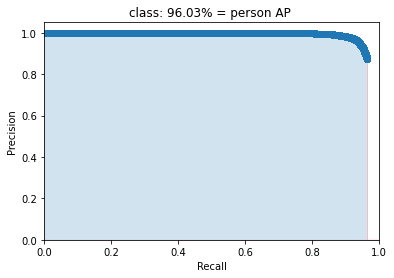

mAP = 96.03%


In [58]:
"""
 Calculate the AP for each class
"""
print("Calculate the AP for each class")
sum_AP = 0.0
ap_dictionary = {}
lamr_dictionary = {}
# open file to store the output
with open(output_files_path + "/output.txt", 'w') as output_file:
    output_file.write("# AP and precision/recall per class\n")
    count_true_positives = {}
    #print(f"gt_classes = {gt_classes}") # gt_classes: ['person']
    for class_index, class_name in enumerate(gt_classes):
        #print(f"Calculate the AP for class {class_index} ({class_name})")

        count_true_positives[class_name] = 0
        """
         Load detection-results of that class
        """
        dr_file = TEMP_FILES_PATH + "/" + class_name + "_dr.json"
        dr_data = json.load(open(dr_file))
        """
         Assign detection-results to ground-truth objects
        """
        nd = len(dr_data) # nd: number of detections for this class
        tp = [0] * nd # creates an array of zeros of size nd
        fp = [0] * nd
        
        conf = [-1] * nd # confidence list
        
        for idx, detection in enumerate(dr_data):            
            
            # ex. of detection: {'confidence': '0.9995710849761963', 'file_id': 'set85_0411', 'bbox': '434 70 795 719'}
            # dr_data is already sorted by condifence (descending order)
            
            file_id = detection["file_id"]
            
            conf[idx] = float(detection['confidence'])
            
            if (idx%100 == 0):
                print(f"{idx} detections")
            
            if show_animation:
                # find ground truth image
                ground_truth_img = glob.glob1(IMG_PATH, file_id + ".*")
                #tifCounter = len(glob.glob1(myPath,"*.tif"))
                if len(ground_truth_img) == 0:
                    error("Error. Image not found with id: " + file_id)
                elif len(ground_truth_img) > 1:
                    error("Error. Multiple image with id: " + file_id)
                else: # found image
                    #print(IMG_PATH + "/" + ground_truth_img[0])
                    # Load image
                    img = cv2.imread(IMG_PATH + "/" + ground_truth_img[0])
                    # load image with draws of multiple detections
                    img_cumulative_path = output_files_path + "/images/" + ground_truth_img[0]
                    if os.path.isfile(img_cumulative_path):
                        img_cumulative = cv2.imread(img_cumulative_path)
                    else:
                        img_cumulative = img.copy()
                    # Add bottom border to image
                    bottom_border = 60
                    BLACK = [0, 0, 0]
                    img = cv2.copyMakeBorder(img, 0, bottom_border, 0, 0, cv2.BORDER_CONSTANT, value=BLACK)
            
            # assign detection-results to ground truth object if any
            # open ground-truth with that file_id
            gt_file = TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json"
            ground_truth_data = json.load(open(gt_file))
            ovmax = -1
            gt_match = -1
            
            # load detected object bounding-box
            bb = [ float(x) for x in detection["bbox"].split() ]
            
            # find an obj in ground-truth maximally overlapped with detection
            for obj in ground_truth_data:
                
                # ex. of obj: {'class_name': 'person', 'bbox': '2 220 250 719', 'used': False, 'used_confidence_level': 0.0}
                
                # look for a class_name match
                if obj["class_name"] == class_name:
                    bbgt = [ float(x) for x in obj["bbox"].split() ]
                    
                    # compute intersection
                    bi = [max(bb[0],bbgt[0]), max(bb[1],bbgt[1]), min(bb[2],bbgt[2]), min(bb[3],bbgt[3])]
                    
                    iw = bi[2] - bi[0] + 1
                    ih = bi[3] - bi[1] + 1
                    if iw > 0 and ih > 0:
                        # compute overlap (IoU) = area of intersection / area of union
                        ua = (bb[2] - bb[0] + 1) * (bb[3] - bb[1] + 1) + (bbgt[2] - bbgt[0]
                                        + 1) * (bbgt[3] - bbgt[1] + 1) - iw * ih
                        ov = iw * ih / ua
                        if ov > ovmax:
                            ovmax = ov
                            gt_match = obj
                            #print("bb = {},{},{},{}".format(bb[0], bb[1], bb[2], bb[3]))
                            #print("gt = {},{},{},{}".format(bbgt[0], bbgt[1], bbgt[2], bbgt[3]))
                            #print("iw = {}, ih = {} --> Intersection = {}".format(iw, ih, iw*ih))
                            #print("Union = {}".format(ua))

            # assign detection as true positive/don't care/false positive
            if show_animation:
                status = "NO MATCH FOUND!" # status is only used in the animation
            
            # set minimum overlap
            min_overlap = MINOVERLAP
            
            if specific_iou_flagged:
                if class_name in specific_iou_classes:
                    index = specific_iou_classes.index(class_name)
                    min_overlap = float(iou_list[index])
            
            #print("ovmax = {}".format(ovmax))
            if ovmax >= min_overlap:
                if "difficult" not in gt_match:
                        if not bool(gt_match["used"]):
                            # true positive
                            tp[idx] = 1
                            gt_match["used"] = True
                            gt_match["used_confidence_level"] = conf[idx]
                            #print("gt_match: ", gt_match)
                            count_true_positives[class_name] += 1
                            # update the ".json" file
                            with open(gt_file, 'w') as f:
                                    f.write(json.dumps(ground_truth_data))
                            if show_animation:
                                status = "MATCH!"
                        else:
                            # false positive (multiple detection)
                            fp[idx] = 1
                            if show_animation:
                                status = "REPEATED MATCH!"
            else:
                # false positive
                fp[idx] = 1
                if ovmax > 0:
                    status = "INSUFFICIENT OVERLAP"

            """
             Draw image to show animation
            """
            if show_animation:
                height, widht = img.shape[:2]
                # colors (OpenCV works with BGR)
                white = (255,255,255)
                light_blue = (255,200,100)
                green = (0,255,0)
                light_red = (30,30,255)
                # 1st line
                margin = 10
                v_pos = int(height - margin - (bottom_border / 2.0))
                text = "Image: " + ground_truth_img[0] + " "
                img, line_width = draw_text_in_image(img, text, (margin, v_pos), white, 0)
                detections_one_by_one_text_file.write(text) # ahnjw, 2020.11.07
                
                text = "Class [" + str(class_index) + "/" + str(n_classes) + "]: " + class_name + " "
                img, line_width = draw_text_in_image(img, text, (margin + line_width, v_pos), light_blue, line_width)
                detections_one_by_one_text_file.write(text) # ahnjw, 2020.11.07

                if ovmax != -1:
                    color = light_red
                    if status == "INSUFFICIENT OVERLAP":
                        text = "IoU: {0:.2f}% ".format(ovmax*100) + "< {0:.2f}% ".format(min_overlap*100)
                    else:
                        text = "IoU: {0:.2f}% ".format(ovmax*100) + ">= {0:.2f}% ".format(min_overlap*100)
                        color = green
                    img, _ = draw_text_in_image(img, text, (margin + line_width, v_pos), color, line_width)
                    detections_one_by_one_text_file.write(text+"\n") # ahnjw, 2020.11.07
                else:
                    detections_one_by_one_text_file.write("ovmax = {}\n".format(ovmax)) # ahnjw, 2020.11.07
                    

                # 2nd line
                v_pos += int(bottom_border / 2.0)
                rank_pos = str(idx+1) # rank position (idx starts at 0)
                text = "Detection #rank: " + rank_pos + " confidence: {0:.2f}% ".format(float(detection["confidence"])*100)
                img, line_width = draw_text_in_image(img, text, (margin, v_pos), white, 0)
                detections_one_by_one_text_file.write(text) # ahnjw, 2020.11.07

                color = light_red
                if status == "MATCH!":
                    color = green
                text = "Result: " + status + " "
                img, line_width = draw_text_in_image(img, text, (margin + line_width, v_pos), color, line_width)
                detections_one_by_one_text_file.write(text+"\n") # ahnjw, 2020.11.07

                font = cv2.FONT_HERSHEY_SIMPLEX
                if ovmax > 0: # if there is intersections between the bounding-boxes
                    bbgt = [ int(round(float(x))) for x in gt_match["bbox"].split() ]
                    cv2.rectangle(img,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),light_blue,2)
                    cv2.rectangle(img_cumulative,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),light_blue,2)
                    cv2.putText(img_cumulative, class_name, (bbgt[0],bbgt[1] - 5), font, 0.6, light_blue, 1, cv2.LINE_AA)
                bb = [int(i) for i in bb]
                cv2.rectangle(img,(bb[0],bb[1]),(bb[2],bb[3]),color,2)
                cv2.rectangle(img_cumulative,(bb[0],bb[1]),(bb[2],bb[3]),color,2)
                cv2.putText(img_cumulative, class_name, (bb[0],bb[1] - 5), font, 0.6, color, 1, cv2.LINE_AA)

                # show image
                """
                cv2.imshow("Animation", img)
                cv2.waitKey(20) # show for 20 ms
                """

                # save image to output
                output_img_path = output_files_path + "/images/detections_one_by_one/" + class_name + "_detection" + str(idx) + "_"+status+".jpg"
                #print("output_img_path = ", output_img_path)
                #cv2.imwrite(output_img_path, img)

                # save the image with all the objects drawn to it
                cv2.imwrite(img_cumulative_path, img_cumulative)

        #print("tp+fp:")
        #print([a + b for a, b in zip(tp, fp)])
        
        # compute precision/recall
        cumsum = 0
        for idx, val in enumerate(fp):
            fp[idx] += cumsum
            cumsum += val
        #print(f"\nfp = {fp}")
            
        cumsum = 0
        for idx, val in enumerate(tp):
            tp[idx] += cumsum
            cumsum += val
        #print(f"\ntp = {tp}")
        
        rec = tp[:]
        for idx, val in enumerate(tp):
            rec[idx] = float(tp[idx]) / gt_counter_per_class[class_name]
        #print(f"\nrecall = {rec}")
        
        prec = tp[:]
        for idx, val in enumerate(tp):
            prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])
        #print(f"\nprecision = {prec}")
        
        #print(f"\nconfidence = {conf}")
        
        conf_tp_fp = []
        for idx, (conf_val, tp_val, fp_val) in enumerate(zip(conf, tp, fp)):
            fn_val = gt_counter_per_class[class_name] - tp_val
            conf_tp_fp.append((conf_val, tp_val, fp_val, fn_val))           
            
            
        #print(f"\nconf_tp_fp = {conf_tp_fp}")
            
        ap, mrec, mprec = voc_ap(rec[:], prec[:])
        sum_AP += ap
        text = "{0:.2f}%".format(ap*100) + " = " + class_name + " AP " #class_name + " AP = {0:.2f}%".format(ap*100)
        
        """
         Write to output.txt
        """
        rounded_prec = [ '%.2f' % elem for elem in prec ]
        rounded_rec = [ '%.2f' % elem for elem in rec ]
        output_file.write(text + "\n Precision: " + str(rounded_prec) + "\n Recall :" + str(rounded_rec) + "\n\n")
        if not args.quiet:
            print(text)
        ap_dictionary[class_name] = ap

        n_images = counter_images_per_class[class_name]
        lamr, mr, fppi = log_average_miss_rate(np.array(prec), np.array(rec), n_images)
        lamr_dictionary[class_name] = lamr

        """
         Draw plot
        """
        print("\n\ndraw_plot = {}\n".format(draw_plot))
        if draw_plot:
            print("Draw precision-recall curve")
            plt.plot(rec, prec, '-o')
            # add a new penultimate point to the list (mrec[-2], 0.0)
            # since the last line segment (and respective area) do not affect the AP value
            area_under_curve_x = mrec[:-1] + [mrec[-2]] + [mrec[-1]]
            #print("area_under_curve_x: ")
            #print(area_under_curve_x)
            area_under_curve_y = mprec[:-1] + [0.0] + [mprec[-1]]
            #print("mprec: ")
            #print(mprec)
            #print("area_under_curve_y: ")
            #print(area_under_curve_y)
            
            #print(f"len(area_under_curve_x = {len(area_under_curve_x)}")
            #print(f"len(area_under_curve_y = {len(area_under_curve_y)}")   
            
            plt.fill_between(area_under_curve_x, 0, area_under_curve_y, alpha=0.2, edgecolor='r')
            # set window title
            fig = plt.gcf() # gcf - get current figure
            fig.canvas.set_window_title('AP ' + class_name)
            # set plot title
            plt.title('class: ' + text)
            #plt.suptitle('This is a somewhat long figure title', fontsize=16)
            # set axis titles
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            # optional - set axes
            axes = plt.gca() # gca - get current axes
            axes.set_xlim([0.0,1.0])
            axes.set_ylim([0.0,1.05]) # .05 to give some extra space
            # Alternative option -> wait for button to be pressed
            #while not plt.waitforbuttonpress(): pass # wait for key display
            # Alternative option -> normal display
            plt.show()
            # save the plot
            fig.savefig(output_files_path + "/classes/" + class_name + ".png")
            #plt.cla() # clear axes for next plot

    if show_animation:
        cv2.destroyAllWindows()

    output_file.write("\n# mAP of all classes\n")
    mAP = sum_AP / n_classes
    text = "mAP = {0:.2f}%".format(mAP*100)
    output_file.write(text + "\n")
    print(text)

In [60]:
slopes = [] # contains delta(precision) / delta(recall) at each confidence level
prev_precision_val = 0
prev_recall_val = 0

with open("f1.csv", "wt") as prec_recall_output:
    prec_recall_output.write("confidence, f1_score, recall, precision")
    for conf_tp_fp_val in conf_tp_fp:
        confidence = conf_tp_fp_val[0]
        precision_val = conf_tp_fp_val[1] / (conf_tp_fp_val[1] + conf_tp_fp_val[2])
        recall_val = conf_tp_fp_val[1] / (conf_tp_fp_val[1] + conf_tp_fp_val[3])
        f1_score = 2 * (precision_val*recall_val)/(precision_val+recall_val)
        prec_recall_output.write(f"{confidence}, {f1_score}, {recall_val}, {precision_val}\n")
        print(f"{confidence}, {f1_score}")
        #print(f"{conf_tp_fp_val}, precision = {precision_val}, recall={recall_val}")
        
print("f1.csv is written.")

0.9996525645256042, 6.975689721321194e-05
0.9996488690376282, 0.00013950892857142854
0.9996358752250671, 0.00020925609458375479
0.9996307492256165, 0.00027899839575922436
0.9996289014816284, 0.0003487358326068004
0.9996266961097717, 0.00041846840563537454
0.9996215105056763, 0.00048819611535376786
0.9996156692504883, 0.0005579189622707301
0.9996142387390137, 0.0006276369468949406
0.9996041059494019, 0.0006973500697350071
0.9996016025543213, 0.0007670583312994666
0.9995986819267273, 0.0008367617320967854
0.9995981454849243, 0.0009064602726353589
0.999595046043396, 0.0009761539534235114
0.999595046043396, 0.0010458427749694963
0.9995891451835632, 0.0011155267377814962
0.9995859861373901, 0.001185205842367623
0.9995853900909424, 0.0012548800892359174
0.9995837211608887, 0.0013245494788943497
0.999581515789032, 0.001394214011850819
0.9995803236961365, 0.001463873688613154
0.9995800852775574, 0.001533528509689112
0.999579131603241, 0.00160317847558638
0.9995790123939514, 0.00167282358681257

0.9963828325271606, 0.13163897034864777
0.9963824152946472, 0.13169984686064318
0.9963814616203308, 0.1317607194057083
0.9963799715042114, 0.13182158798423094
0.9963791966438293, 0.1318824525965987
0.9963764548301697, 0.13194331324319922
0.9963757991790771, 0.13200416992442013
0.9963753819465637, 0.13206502264064893
0.9963752627372742, 0.1321258713922731
0.9963738322257996, 0.1321867161796801
0.996372640132904, 0.13224755700325735
0.9963718056678772, 0.13230839386339208
0.9963712096214294, 0.13236922676047164
0.9963706731796265, 0.13243005569488323
0.9963706135749817, 0.13249088066701406
0.9963703751564026, 0.13255170167725125
0.9963703751564026, 0.1326125187259819
0.9963699579238892, 0.132673331813593
0.9963696002960205, 0.13273414094047153
0.9963694214820862, 0.13279494610700446
0.9963691830635071, 0.13285574731357863
0.9963688850402832, 0.13291654456058088
0.9963688254356384, 0.13297733784839805
0.9963676929473877, 0.13303812717741673
0.9963654279708862, 0.1330989125480237
0.9963644

0.9948803782463074, 0.26473792519065487
0.9948795437812805, 0.2647904372824936
0.994878888130188, 0.26484294619621135
0.994878888130188, 0.2648954519320967
0.9948763847351074, 0.2649479544904382
0.9948751926422119, 0.26500045387152416
0.9948741793632507, 0.26505295007564295
0.994873046875, 0.2651054431030831
0.9948717951774597, 0.26515793295413287
0.994871199131012, 0.2652104196290806
0.9948705434799194, 0.2652629031282145
0.9948694109916687, 0.2653153834518227
0.9948689341545105, 0.26536786060019363
0.9948686361312866, 0.26542033457361525
0.9948673248291016, 0.2654728053723758
0.9948663711547852, 0.2655252729967633
0.9948660135269165, 0.265577737447066
0.9948658347129822, 0.2656301987235716
0.9948647022247314, 0.2656826568265683
0.994864284992218, 0.26573511175634396
0.9948636889457703, 0.2657875635131865
0.9948631525039673, 0.26584001209738395
0.9948627948760986, 0.265892457509224
0.9948620796203613, 0.26594489974899443
0.9948620200157166, 0.2659973388169832
0.994861900806427, 0.2660

0.9925133585929871, 0.38264744873494483
0.9925100207328796, 0.3826930670728268
0.9925099015235901, 0.38273868283739954
0.9925088286399841, 0.3827842960288809
0.992508590221405, 0.3828299066474885
0.992508590221405, 0.3828755146934401
0.9925079941749573, 0.38292112016695334
0.9925075769424438, 0.38296672306824586
0.9925049543380737, 0.3830123233975354
0.9925035834312439, 0.38305792115503917
0.9925026297569275, 0.3831035163409751
0.9925006031990051, 0.3831491089555606
0.9924997687339783, 0.3831946989990131
0.9924994111061096, 0.38324028647155023
0.9924992918968201, 0.3832858713733894
0.9924988746643066, 0.3833314537047479
0.9924957752227783, 0.3833770334658434
0.9924952387809753, 0.38342261065689315
0.9924951791763306, 0.3834681852781145
0.9924932718276978, 0.3835137573297248
0.9924924373626709, 0.3835593268119415
0.9924907088279724, 0.3836048937249817
0.9924903512001038, 0.3836504580690627
0.9924892783164978, 0.3836960198444019
0.9924873113632202, 0.38374157905121625
0.9924868941307068,

0.9888229966163635, 0.4754460131344553
0.988820493221283, 0.475486546846751
0.9888186454772949, 0.4755270784037434
0.9888173341751099, 0.47556760780560425
0.9888157248497009, 0.47560813505250565
0.9888098835945129, 0.4756486601446193
0.9888098835945129, 0.47568918308211716
0.9888098835945129, 0.475729703865171
0.9888085722923279, 0.47577022249395257
0.988808274269104, 0.4758107389686337
0.9888079166412354, 0.47585125328938627
0.9888031482696533, 0.4758917654563819
0.9888020753860474, 0.47593227546979233
0.9888014197349548, 0.4759727833297895
0.9887986779212952, 0.4760132890365449
0.9887926578521729, 0.4760537925902301
0.9887919425964355, 0.4760942939910171
0.9887918829917908, 0.47613479323907726
0.9887902140617371, 0.4761752903345824
0.9887865781784058, 0.47621578527770403
0.9887829422950745, 0.47625627806861365
0.988782525062561, 0.476296768707483
0.9887822270393372, 0.4763372571944836
0.9887815713882446, 0.4763777435297869
0.9887795448303223, 0.47641822771356446
0.9887773990631104, 0

0.9832334518432617, 0.5517136867628116
0.9832280278205872, 0.5517502651916957
0.983216404914856, 0.5517868417729512
0.9832143783569336, 0.5518234165067178
0.9832139015197754, 0.5518599893931357
0.9832134246826172, 0.551896560432345
0.9832115769386292, 0.5519331296244855
0.9831981062889099, 0.5519696969696969
0.9831979274749756, 0.5520062624681196
0.9831880927085876, 0.5520428261198929
0.9831809401512146, 0.5520793879251571
0.9831795692443848, 0.5521159478840522
0.983178436756134, 0.5521525059967176
0.983177125453949, 0.5521890622632935
0.9831768274307251, 0.5522256166839196
0.9831763505935669, 0.5522621692587356
0.9831641316413879, 0.5522987199878815
0.9831615686416626, 0.5523352688714972
0.983155369758606, 0.552371815909722
0.9831544160842896, 0.5524083611026961
0.9831523895263672, 0.5524449044505592
0.9831521511077881, 0.5524814459534508
0.983148992061615, 0.5525179856115108
0.9831482172012329, 0.5525545234248788
0.9831451773643494, 0.5525910593936946
0.9831439852714539, 0.5526275935

0.9744097590446472, 0.6307394761347629
0.9744083881378174, 0.6307721694283942
0.9743962287902832, 0.6308048611608528
0.9743920564651489, 0.6308375513322508
0.9743911623954773, 0.6308702399427002
0.9743905663490295, 0.6309029269923125
0.9743867516517639, 0.6309356124811994
0.9743855595588684, 0.6309682964094729
0.9743817448616028, 0.6310009787772446
0.9743791222572327, 0.6310336595846264
0.9743770956993103, 0.63106633883173
0.974367082118988, 0.6310990165186671
0.9743644595146179, 0.6311316926455494
0.9743567705154419, 0.6311643672124887
0.9743563532829285, 0.6311970402195966
0.9743507504463196, 0.6312297116669849
0.9743301868438721, 0.6312623815547652
0.9743204116821289, 0.6312950498830493
0.9743156433105469, 0.6313277166519488
0.974312961101532, 0.6313603818615752
0.9742989540100098, 0.6313930455120403
0.9742880463600159, 0.6314257076034556
0.9742833971977234, 0.6314583681359329
0.9742828011512756, 0.6314910271095838
0.9742630124092102, 0.6315236845245197
0.9742608666419983, 0.6315563

0.9588215947151184, 0.7050986767827304
0.9588095545768738, 0.705127915641159
0.9587907791137695, 0.7051571531791907
0.9587893486022949, 0.7051863893969158
0.9587849378585815, 0.7052156242944231
0.9587767124176025, 0.7052448578718024
0.9587693214416504, 0.7052740901291429
0.9587596654891968, 0.7053033210665342
0.9587490558624268, 0.7052873978416941
0.9587450623512268, 0.7053166271588215
0.9587404131889343, 0.7053458551562218
0.9587204456329346, 0.7053750818339842
0.9587103724479675, 0.7054043071921984
0.9587103724479675, 0.7054335312309534
0.9586703777313232, 0.7054627539503386
0.9586684703826904, 0.7054919753504435
0.9586616158485413, 0.7055211954313575
0.9586610198020935, 0.7055504141931698
0.9586470127105713, 0.7055796316359698
0.9586445689201355, 0.7056088477598464
0.9586329460144043, 0.7056380625648896
0.9586296677589417, 0.7056672760511883
0.9586294293403625, 0.7056964882188318
0.9586092233657837, 0.7057256990679094
0.9586080312728882, 0.7057549085985105
0.9586042761802673, 0.7057

0.9374589920043945, 0.7634631138705644
0.9374375939369202, 0.7634897708409684
0.9374110698699951, 0.7635164266620679
0.937398374080658, 0.7635430813339369
0.93739253282547, 0.7635697348566503
0.9373870491981506, 0.7635963872302818
0.9373778700828552, 0.763623038454906
0.9373480677604675, 0.7636496885305972
0.9373457431793213, 0.7636763374574298
0.9373323917388916, 0.763702985235478
0.9373271465301514, 0.763729631864816
0.9373120069503784, 0.763756277345518
0.9372909069061279, 0.7637829216776585
0.9372831583023071, 0.7638095648613118
0.9372701644897461, 0.7638362068965517
0.9372617602348328, 0.763862847783453
0.9372431039810181, 0.7638894875220895
0.937224805355072, 0.7639161261125358
0.9372233152389526, 0.7639427635548659
0.9372076988220215, 0.7639693998491542
0.9371916055679321, 0.7639960349954747
0.937187671661377, 0.7640226689939018
0.9371795654296875, 0.7640493018445095
0.9371727108955383, 0.7640759335473724
0.9371627569198608, 0.764102564102564
0.9371535778045654, 0.76412919351015

0.9069530367851257, 0.8093034836193125
0.9068924784660339, 0.8093281878916138
0.9068875312805176, 0.8093528911388204
0.9068872928619385, 0.8093775933609959
0.9068395495414734, 0.8094022945582041
0.9067923426628113, 0.8094269947305092
0.906772255897522, 0.8094516938779744
0.9067686796188354, 0.8094763920006639
0.9067648649215698, 0.8095010890986412
0.9067167043685913, 0.8095257851719704
0.9067094922065735, 0.8095504802207149
0.9066582918167114, 0.8095751742449385
0.906653106212616, 0.8095998672447055
0.9066179990768433, 0.8096245592200787
0.9066120982170105, 0.8096492501711227
0.9065849184989929, 0.809673940097901
0.906576931476593, 0.809698629000477
0.9065762758255005, 0.809723316878915
0.9065712094306946, 0.809748003733278
0.9065419435501099, 0.8097726895636302
0.9065326452255249, 0.8097973743700354
0.9065178632736206, 0.8098220581525571
0.9064692258834839, 0.8098467409112589
0.9064578413963318, 0.8098714226462049
0.9064090847969055, 0.8098961033574585
0.9064059257507324, 0.8099207830

0.86264568567276, 0.8503883417407319
0.8626093864440918, 0.8504113537642373
0.8626078367233276, 0.8504343648664877
0.8625279664993286, 0.850457375047539
0.8625175356864929, 0.8504803843074459
0.8624385595321655, 0.8505033926462641
0.8624048233032227, 0.8505264000640488
0.8623923063278198, 0.850549406560855
0.8623033165931702, 0.8505724121367385
0.8622921705245972, 0.8505954167917542
0.8622608780860901, 0.8506184205259577
0.8622568249702454, 0.8506414233394041
0.8622170686721802, 0.8506644252321486
0.8622021079063416, 0.8506874262042466
0.8621773719787598, 0.8507104262557534
0.8621643781661987, 0.8507334253867244
0.8620533347129822, 0.8507564235972145
0.8619958162307739, 0.8507794208872791
0.8619418144226074, 0.8508024172569736
0.861931324005127, 0.8508254127063533
0.8618856072425842, 0.850848407235473
0.8618797659873962, 0.8508714008443884
0.8618675470352173, 0.8508943935331545
0.861867368221283, 0.8509173853018268
0.8617004752159119, 0.8509403761504601
0.8616725206375122, 0.8509633660

0.7829383015632629, 0.8938886965885928
0.7829380631446838, 0.8939099667326884
0.7828848361968994, 0.8939312360587648
0.7828032374382019, 0.8939525045668686
0.7827922105789185, 0.8939737722570473
0.7827302813529968, 0.8939565827677042
0.7826939225196838, 0.8939778495616059
0.782684326171875, 0.8939991155376954
0.7826481461524963, 0.8939819265525861
0.7824780941009521, 0.8940031916325393
0.782329797744751, 0.8940244558947935
0.7823222875595093, 0.8940457193393959
0.7822988033294678, 0.8940669819663937
0.7822799682617188, 0.8940497933288475
0.7822470664978027, 0.8940710550599816
0.7822213172912598, 0.8940538670050177
0.7822056412696838, 0.894075127840363
0.7821805477142334, 0.8940963878582825
0.7820008993148804, 0.8941176470588235
0.7819978594779968, 0.894138905442033
0.781974196434021, 0.8941601630079581
0.781936764717102, 0.8941814197566461
0.7819336652755737, 0.8942026756881439
0.7817866206169128, 0.8942239308024987
0.781764805316925, 0.8942451850997578
0.7813621759414673, 0.8942664385

0.6044483184814453, 0.9325925380822725
0.6044442057609558, 0.9326121750648491
0.604422390460968, 0.93263181132492
0.6042385697364807, 0.9326514468625251
0.6039866209030151, 0.9326710816777042
0.6039856672286987, 0.9326907157704971
0.6039315462112427, 0.932710349140944
0.6036667823791504, 0.9327299817890844
0.6034418940544128, 0.9327496137149583
0.6033666729927063, 0.9327324565437323
0.6031444668769836, 0.9327520877018726
0.6031171083450317, 0.9327349311163022
0.6029887199401855, 0.9327545615067686
0.6029808521270752, 0.9327374055068145
0.6028768420219421, 0.9327202501379437
0.6027458310127258, 0.9327398797152894
0.6027029752731323, 0.9327595085705879
0.6026900410652161, 0.9327791367038788
0.6025538444519043, 0.9327987641152021
0.6025255918502808, 0.9327816091954022
0.6025208830833435, 0.9328012358393409
0.6025100946426392, 0.9328208617614066
0.6024516224861145, 0.9328404869616388
0.6021760106086731, 0.9328601114400781
0.6020843386650085, 0.9328429569694742
0.6020763516426086, 0.9328258

0.30339232087135315, 0.9461878685762427
0.3032938838005066, 0.946171262088211
0.30319052934646606, 0.9461546561830881
0.3029956817626953, 0.9461380508608436
0.30294308066368103, 0.9461214461214461
0.3028128743171692, 0.9461399413839702
0.3025764524936676, 0.9461233371942017
0.30237877368927, 0.9461067335872102
0.30233266949653625, 0.9461252281342131
0.3023129105567932, 0.9461086250767746
0.30226778984069824, 0.9460920226020425
0.3022153973579407, 0.9460754207099865
0.30221298336982727, 0.9460588194005756
0.3020109534263611, 0.9460773131656987
0.30196213722229004, 0.9460607124056852
0.3017626106739044, 0.946079205488586
0.30173662304878235, 0.9460626052779337
0.30134132504463196, 0.9460460056498167
0.3012871742248535, 0.946029406604204
0.3011932075023651, 0.946012808141065
0.30112603306770325, 0.9459962102603692
0.30112236738204956, 0.9459796129620858
0.3008490204811096, 0.9459981051966736
0.30080845952033997, 0.9459815084475167
0.30058425664901733, 0.9459649122807017
0.3004646003246307

0.13731098175048828, 0.9284894708423326
0.1372872292995453, 0.9284738041002277
0.1371879279613495, 0.9284581378868154
0.13716885447502136, 0.9284424722020685
0.13708586990833282, 0.9284268070459606
0.13706359267234802, 0.9284111424184649
0.13706228137016296, 0.9283954783195546
0.1370076835155487, 0.9283798147492028
0.13695085048675537, 0.9283641517073828
0.13681893050670624, 0.9283484891940681
0.1368151754140854, 0.9283328272092317
0.13677173852920532, 0.9283171657528468
0.13675259053707123, 0.928301504824887
0.13674688339233398, 0.9282858444253252
0.1367282122373581, 0.9282701845541347
0.13672669231891632, 0.9282882639720643
0.13672539591789246, 0.9283063427800271
0.1366167515516281, 0.9282906833555439
0.13652801513671875, 0.9283087615127694
0.13652224838733673, 0.9282931025757806
0.1365075260400772, 0.9282774441670603
0.13643711805343628, 0.9282617862865817
0.13641183078289032, 0.9282798637115002
0.13638406991958618, 0.9282642063184172
0.1363193690776825, 0.928248549453515
0.13630321

In [36]:
"""
 Draw false negatives
"""
if show_animation:
    pink = (203,192,255)
    for tmp_file in gt_files:
        ground_truth_data = json.load(open(tmp_file))
        #print(ground_truth_data)
        # get name of corresponding image
        start = TEMP_FILES_PATH + '/'
        img_id = tmp_file[tmp_file.find(start)+len(start):tmp_file.rfind('_ground_truth.json')]
        img_cumulative_path = output_files_path + "/images/" + img_id + ".jpg"
        img = cv2.imread(img_cumulative_path)
        if img is None:
            img_path = IMG_PATH + '/' + img_id + ".jpg"
            img = cv2.imread(img_path)
        # draw false negatives
        for obj in ground_truth_data:
            if not obj['used']:
                bbgt = [ int(round(float(x))) for x in obj["bbox"].split() ]
                cv2.rectangle(img,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),pink,2)
        cv2.imwrite(img_cumulative_path, img)

"""
Draw false negatives when confidence level of relevant detections falls between CONF_THRESH1 and CONF_THRESH2
(This is for investigating false negatives when we raise the conf_thresh of the detector from CONF_THRESH1 to CONF_THRESH2)
-- ahnjw,2022.07.10
"""
       
        
        
# remove the temp_files directory
shutil.rmtree(TEMP_FILES_PATH)

In [37]:
"""
 Count total of detection-results
"""
# iterate through all the files
det_counter_per_class = {}
for txt_file in dr_files_list:
    # get lines to list
    lines_list = file_lines_to_list(txt_file)
    for line in lines_list:
        class_name = line.split()[0]
        # check if class is in the ignore list, if yes skip
        if class_name in args.ignore:
            continue
        # count that object
        if class_name in det_counter_per_class:
            det_counter_per_class[class_name] += 1
        else:
            # if class didn't exist yet
            det_counter_per_class[class_name] = 1
#print(det_counter_per_class)
dr_classes = list(det_counter_per_class.keys())

In [38]:
"""
 Plot the total number of occurences of each class in the ground-truth
"""
if draw_plot:
    window_title = "ground-truth-info"
    plot_title = "ground-truth\n"
    plot_title += "(" + str(len(ground_truth_files_list)) + " files and " + str(n_classes) + " classes)"
    x_label = "Number of objects per class"
    output_path = output_files_path + "/ground-truth-info.png"
    to_show = False
    plot_color = 'forestgreen'
    draw_plot_func(
        gt_counter_per_class,
        n_classes,
        window_title,
        plot_title,
        x_label,
        output_path,
        to_show,
        plot_color,
        '',
        )

In [39]:
"""
 Write number of ground-truth objects per class to results.txt
"""
with open(output_files_path + "/output.txt", 'a') as output_file:
    output_file.write("\n# Number of ground-truth objects per class\n")
    for class_name in sorted(gt_counter_per_class):
        output_file.write(class_name + ": " + str(gt_counter_per_class[class_name]) + "\n")


In [40]:
"""
 Finish counting true positives
"""
for class_name in dr_classes:
    # if class exists in detection-result but not in ground-truth then there are no true positives in that class
    if class_name not in gt_classes:
        count_true_positives[class_name] = 0
#print(count_true_positives)

In [41]:
"""
 Plot the total number of occurences of each class in the "detection-results" folder
"""
if draw_plot:
    window_title = "detection-results-info"
    # Plot title
    plot_title = "detection-results\n"
    plot_title += "(" + str(len(dr_files_list)) + " files and "
    count_non_zero_values_in_dictionary = sum(int(x) > 0 for x in list(det_counter_per_class.values()))
    plot_title += str(count_non_zero_values_in_dictionary) + " detected classes)"
    # end Plot title
    x_label = "Number of objects per class"
    output_path = output_files_path + "/detection-results-info.png"
    to_show = False
    plot_color = 'forestgreen'
    true_p_bar = count_true_positives
    draw_plot_func(
        det_counter_per_class,
        len(det_counter_per_class),
        window_title,
        plot_title,
        x_label,
        output_path,
        to_show,
        plot_color,
        true_p_bar
        )

In [42]:
"""
 Write number of detected objects per class to output.txt
"""
with open(output_files_path + "/output.txt", 'a') as output_file:
    output_file.write("\n# Number of detected objects per class\n")
    for class_name in sorted(dr_classes):
        n_det = det_counter_per_class[class_name]
        text = class_name + ": " + str(n_det)
        text += " (tp:" + str(count_true_positives[class_name]) + ""
        text += ", fp:" + str(n_det - count_true_positives[class_name]) + ")\n"
        output_file.write(text)

In [43]:
"""
 Draw log-average miss rate plot (Show lamr of all classes in decreasing order)
"""
if draw_plot:
    window_title = "lamr"
    plot_title = "log-average miss rate"
    x_label = "log-average miss rate"
    output_path = output_files_path + "/lamr.png"
    to_show = False
    plot_color = 'royalblue'
    draw_plot_func(
        lamr_dictionary,
        n_classes,
        window_title,
        plot_title,
        x_label,
        output_path,
        to_show,
        plot_color,
        ""
        )

In [44]:
"""
 Draw mAP plot (Show AP's of all classes in decreasing order)
"""
if draw_plot:
    window_title = "mAP"
    plot_title = "mAP = {0:.2f}%".format(mAP*100)
    x_label = "Average Precision"
    output_path = output_files_path + "/mAP.png"
    #to_show = True
    to_show = False
    plot_color = 'royalblue'
    draw_plot_func(
        ap_dictionary,
        n_classes,
        window_title,
        plot_title,
        x_label,
        output_path,
        to_show,
        plot_color,
        ""
        )

In [45]:
print("End of program.")

End of program.
